In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 256 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


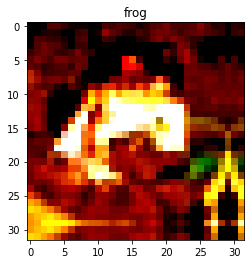

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_adam_batch256_lr01.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.1
lr_min=0.001
momentum = 0.9
nesterov = True
#optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4) # changable optimizer
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9) # changable optimizer
optimizer = torch.optim.Adam(model1.parameters(),lr=lr, betas=(0.9,0.999), eps=1e-08, amsgrad=False) # changable optimize


if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 3.08557021252963, Test loss 1.8742329776287079, Train accuracy 21.481186224489797, Test accuracy 31.435546875, Cost 53.56019878387451 s
Epoch 2, Train loss 1.853005970010952, Test loss 1.7750360637903213, Train accuracy 30.97656250973137, Test accuracy 33.564453125, Cost 53.45768928527832 s
Epoch 3, Train loss 1.7198907459268764, Test loss 1.6362901747226715, Train accuracy 36.05269451530612, Test accuracy 39.7265625, Cost 53.3408203125 s
Epoch 4, Train loss 1.6077226740973336, Test loss 1.4612565964460373, Train accuracy 40.80317283163265, Test accuracy 45.908203125, Cost 53.39960861206055 s
Epoch 5, Train loss 1.479760039217618, Test loss 1.365694835782051, Train accuracy 45.76132015306123, Test accuracy 50.400390625, Cost 53.38847756385803 s
Model saved in epoch 5
Epoch 6, Train loss 1.3871070596636559, Test loss 1.2637492030858994, Train accuracy 49.24107142857143, Test accuracy 53.45703125, Cost 53.420265674591064 s
Epoch 7, Train loss 1.2936376120362962, Test 

Epoch 52, Train loss 0.24437748230233483, Test loss 0.37403401397168634, Train accuracy 91.74665178571429, Test accuracy 88.701171875, Cost 104.5009229183197 s
Epoch 53, Train loss 0.23998722753354482, Test loss 0.3867993842810392, Train accuracy 92.05516581632654, Test accuracy 87.978515625, Cost 104.00613737106323 s
Epoch 54, Train loss 0.23270405045881562, Test loss 0.3790770281106234, Train accuracy 92.19188456632654, Test accuracy 88.505859375, Cost 103.29393291473389 s
Epoch 55, Train loss 0.23143400662407584, Test loss 0.4211504764854908, Train accuracy 92.12492028061224, Test accuracy 88.0859375, Cost 103.61587285995483 s
Model saved in epoch 55
Epoch 56, Train loss 0.22427854500710964, Test loss 0.4027478087693453, Train accuracy 92.4673150510204, Test accuracy 88.02734375, Cost 106.57423257827759 s
Epoch 57, Train loss 0.22737682873041046, Test loss 0.39236426502466204, Train accuracy 92.37723214285714, Test accuracy 88.61328125, Cost 104.02096199989319 s
Epoch 58, Train loss

Epoch 102, Train loss 0.11337859808866467, Test loss 0.4566090665757656, Train accuracy 96.34566326530613, Test accuracy 89.31640625, Cost 105.6467056274414 s
Epoch 103, Train loss 0.10428328903353944, Test loss 0.4367335427552462, Train accuracy 96.58801020408163, Test accuracy 90.21484375, Cost 103.97587704658508 s
Epoch 104, Train loss 0.10349031119626395, Test loss 0.4375265948474407, Train accuracy 96.66573660714286, Test accuracy 90.1171875, Cost 105.54057574272156 s
Epoch 105, Train loss 0.10071528179342953, Test loss 0.4258855443447828, Train accuracy 96.68287627551021, Test accuracy 90.546875, Cost 103.86441898345947 s
Model saved in epoch 105
Epoch 106, Train loss 0.10487813544364608, Test loss 0.43625277616083624, Train accuracy 96.62946428571429, Test accuracy 90.537109375, Cost 103.3317928314209 s
Epoch 107, Train loss 0.1018199760143702, Test loss 0.4082686103880405, Train accuracy 96.7139668367347, Test accuracy 89.82421875, Cost 105.55848550796509 s
Epoch 108, Train los

Epoch 152, Train loss 0.06517209522236063, Test loss 0.4557405985891819, Train accuracy 97.98588966836735, Test accuracy 90.205078125, Cost 105.33437037467957 s
Epoch 153, Train loss 0.06976827305304456, Test loss 0.5207276985049247, Train accuracy 97.9037786989796, Test accuracy 90.29296875, Cost 104.38175296783447 s
Epoch 154, Train loss 0.06945112298660892, Test loss 0.4993015959858894, Train accuracy 97.76666135204081, Test accuracy 90.107421875, Cost 104.25560593605042 s
Epoch 155, Train loss 0.06748299590996182, Test loss 0.48503994308412074, Train accuracy 97.90696747448979, Test accuracy 89.814453125, Cost 104.65421175956726 s
Model saved in epoch 155
Epoch 156, Train loss 0.06701725011463372, Test loss 0.5856171540915966, Train accuracy 97.87507971938776, Test accuracy 90.458984375, Cost 105.61101365089417 s
Epoch 157, Train loss 0.0648263279320102, Test loss 0.5352730073034764, Train accuracy 97.99824617346938, Test accuracy 90.01953125, Cost 104.78608393669128 s
Epoch 158, T

Epoch 202, Train loss 0.04477643447082338, Test loss 0.5575690105557441, Train accuracy 98.63241390306122, Test accuracy 90.810546875, Cost 76.03515696525574 s
Epoch 203, Train loss 0.05864417014111366, Test loss 0.6063634656369686, Train accuracy 98.2242506377551, Test accuracy 90.37109375, Cost 76.20336771011353 s
Epoch 204, Train loss 0.051541338211438636, Test loss 0.561054889112711, Train accuracy 98.47696109693878, Test accuracy 90.48828125, Cost 75.99535965919495 s
Epoch 205, Train loss 0.05024111193927879, Test loss 0.5197959274053574, Train accuracy 98.50207270408163, Test accuracy 90.87890625, Cost 75.99928450584412 s
Model saved in epoch 205
Epoch 206, Train loss 0.04621511508891245, Test loss 0.5111680068075657, Train accuracy 98.5805963010204, Test accuracy 91.15234375, Cost 76.21470975875854 s
Epoch 207, Train loss 0.04788235261589669, Test loss 0.5119955375790596, Train accuracy 98.51124043367346, Test accuracy 90.56640625, Cost 76.18662238121033 s
Epoch 208, Train loss 

Epoch 253, Train loss 0.04371964306646616, Test loss 0.5156753826886415, Train accuracy 98.68064413265306, Test accuracy 90.9765625, Cost 76.12789297103882 s
Epoch 254, Train loss 0.039912105126933634, Test loss 0.6291076518595219, Train accuracy 98.78786670918367, Test accuracy 90.625, Cost 76.18563175201416 s
Epoch 255, Train loss 0.04525052392926561, Test loss 0.5611131347715854, Train accuracy 98.68343431122449, Test accuracy 90.95703125, Cost 76.0553195476532 s
Model saved in epoch 255
Epoch 256, Train loss 0.045467158930366666, Test loss 0.6646620914340019, Train accuracy 98.67267219387755, Test accuracy 90.634765625, Cost 76.06255030632019 s
Epoch 257, Train loss 0.04328944765230907, Test loss 0.5650218404829502, Train accuracy 98.72807716836735, Test accuracy 90.810546875, Cost 76.06690168380737 s
Epoch 258, Train loss 0.03901248293268323, Test loss 0.5858511053025722, Train accuracy 98.84367028061224, Test accuracy 91.23046875, Cost 75.91991901397705 s
Epoch 259, Train loss 0.

Epoch 304, Train loss 0.03993124624818792, Test loss 0.5099578220397234, Train accuracy 98.86160714285714, Test accuracy 91.474609375, Cost 76.11304664611816 s
Epoch 305, Train loss 0.03481643503099414, Test loss 0.5469494998455048, Train accuracy 99.00271045918367, Test accuracy 91.3671875, Cost 76.21811413764954 s
Model saved in epoch 305
Epoch 306, Train loss 0.03288544911406554, Test loss 0.5301432959735394, Train accuracy 99.00709502551021, Test accuracy 90.9765625, Cost 76.05422782897949 s
Epoch 307, Train loss 0.031419100949353046, Test loss 0.5367780443280935, Train accuracy 99.09279336734694, Test accuracy 91.376953125, Cost 76.1702332496643 s
Epoch 308, Train loss 0.032779773504221434, Test loss 0.5327639423310757, Train accuracy 99.05652104591837, Test accuracy 91.142578125, Cost 76.00949621200562 s
Epoch 309, Train loss 0.03182318180856504, Test loss 0.5481671452522278, Train accuracy 99.08322704081633, Test accuracy 91.689453125, Cost 75.8533227443695 s
Epoch 310, Train lo

Epoch 355, Train loss 0.032808238543612804, Test loss 0.6071476534008979, Train accuracy 99.1031568877551, Test accuracy 90.751953125, Cost 76.06338357925415 s
Model saved in epoch 355
Epoch 356, Train loss 0.028195763792609796, Test loss 0.6240355275571347, Train accuracy 99.22273596938776, Test accuracy 91.064453125, Cost 76.0686182975769 s
Epoch 357, Train loss 0.028810022107791156, Test loss 0.5384193383157253, Train accuracy 99.2319036989796, Test accuracy 90.771484375, Cost 76.20288753509521 s
Epoch 358, Train loss 0.026921581896111057, Test loss 0.6703664399683475, Train accuracy 99.1649394132653, Test accuracy 91.85546875, Cost 76.17355251312256 s
Epoch 359, Train loss 0.02834642315614548, Test loss 0.6043528094887733, Train accuracy 99.17610012755102, Test accuracy 91.201171875, Cost 76.09753346443176 s
Epoch 360, Train loss 0.029479016172129432, Test loss 0.6680857636034488, Train accuracy 99.14859693877551, Test accuracy 91.064453125, Cost 75.78277945518494 s
Model saved in 

Epoch 405, Train loss 0.02505228572809589, Test loss 0.6180568017065525, Train accuracy 99.24067283163265, Test accuracy 91.2109375, Cost 76.13044738769531 s
Model saved in epoch 405
Epoch 406, Train loss 0.02422882279932644, Test loss 0.7361085653305054, Train accuracy 99.33553890306122, Test accuracy 90.64453125, Cost 76.05707144737244 s
Epoch 407, Train loss 0.030013275865527173, Test loss 0.6387057341635227, Train accuracy 99.14500956632654, Test accuracy 91.2890625, Cost 75.91602969169617 s
Epoch 408, Train loss 0.021956680452733832, Test loss 0.6661266714334488, Train accuracy 99.39213966836735, Test accuracy 91.044921875, Cost 76.02540183067322 s
Epoch 409, Train loss 0.023056102439503384, Test loss 0.6625882036983967, Train accuracy 99.34032206632654, Test accuracy 90.849609375, Cost 75.88145089149475 s
Epoch 410, Train loss 0.025530010961027038, Test loss 0.5659321032464504, Train accuracy 99.26658163265306, Test accuracy 91.416015625, Cost 75.94326853752136 s
Model saved in e

Epoch 455, Train loss 0.019973406469944166, Test loss 0.6409994289278984, Train accuracy 99.44595025510205, Test accuracy 91.5234375, Cost 62.61431956291199 s
Model saved in epoch 455
Epoch 456, Train loss 0.03108249065627781, Test loss 0.5659507293254137, Train accuracy 99.16454081632654, Test accuracy 91.318359375, Cost 53.04412817955017 s
Epoch 457, Train loss 0.021015155852869703, Test loss 0.6981247819960117, Train accuracy 99.43399234693878, Test accuracy 91.181640625, Cost 53.2427179813385 s
Epoch 458, Train loss 0.025293014654046285, Test loss 0.7422559529542923, Train accuracy 99.28651147959184, Test accuracy 91.357421875, Cost 53.208887577056885 s
Epoch 459, Train loss 0.02001613773015323, Test loss 0.7228840015828609, Train accuracy 99.4140625, Test accuracy 91.181640625, Cost 53.18922662734985 s
Epoch 460, Train loss 0.025599382703928444, Test loss 0.7148275598883629, Train accuracy 99.31242028061224, Test accuracy 91.455078125, Cost 53.22046113014221 s
Model saved in epoch

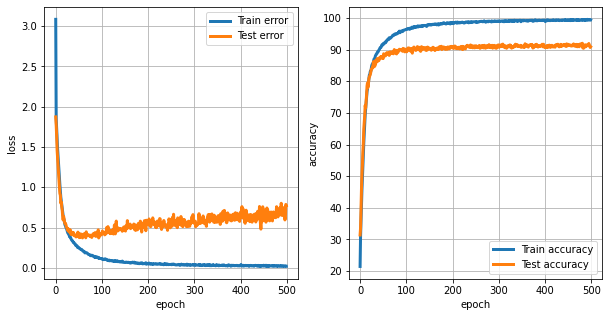

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [11]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5,100-sum(test_accuracy_history[-5:])/5)

Accuracy: 91.1875 8.8125
